# Heat budget in ECCOv4r5


Using https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Heat_budget_closure.html as reference

Things I had to change
- The .compute had to be removed from adv and diff
- had to change the save netcdf cell with encoding issues. forcing was float64 and others were float32
- removing the format='netcdf4' fixes the hdf error!!??, still comes up though!!
- had to save each term separately

In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr


In [2]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [4]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

## METHOD 1: LOADING FILES STORED ON A "LOCAL" DISK

### FIND THE GRANULES

Many ECCO V4r5 fields are stored on the /efs_ecco disk
```
Native Grid:
    monthly means    /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/
    daily snapshots  /efs_ecco/ECCO/V4/r5/netcdf/native/snap/
    geometry         /efs_ecco/ECCO/V4/r5/netcdf/native/geometry
    
Latlon Grid
    monthly means    /efs_ecco/ECCO/V4/r5/netcdf/latlon/mon_mean
    geometry         /efs_ecco/ECCO/V4/r5/netcdf/latlon/geometry
```

Let's start by opening and plotting one of these fields, 


### Locating monthly mean terms

In [5]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    print(str(i).zfill(3),d)

000 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/.ipynb_checkpoints
001 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES
002 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_FRONT_FLUX
003 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_SHELF_FLUX
004 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_X
005 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_Y
006 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_X
007 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_Y
008 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_X
009 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y
010 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX
011 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX
012 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS
013 /efs_ecco/ECCO/V4/r5/netcdf/nativ

### Locating monthly snapshots

In [6]:
# local path to monthly-snapshots native grid datasets
ecco_v4r5_mon_mean_native_snap_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/snap/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_snap_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_snap_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_snap_dataset_paths):
    print(str(i).zfill(3),d)

000 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/OCEAN_BOTTOM_PRESSURE
001 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/OCEAN_TEMPERATURE_SALINITY
002 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/SEA_ICE_CONC_THICKNESS
003 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/SEA_ICE_VELOCITY
004 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/SEA_SURFACE_HEIGHT


### Now, we read the datasets

#### Get the filenames for some dataset

In [7]:
# Select a dataset (the one containing temperature and salinity)
dataset_num_TS = 1
dataset_num_temp_flux = 19
dataset_num_surf_heat_flux = 11
dataset_num_ssh = 4


print('selected ', ecco_v4r5_mon_mean_native_snap_dataset_paths[dataset_num_TS])
TS_dataset_dir = ecco_v4r5_mon_mean_native_snap_dataset_paths[dataset_num_TS]

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num_temp_flux])
temp_flux_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num_temp_flux]


print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num_surf_heat_flux])
surf_heat_flux_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num_surf_heat_flux]

print('selected ', ecco_v4r5_mon_mean_native_snap_dataset_paths[dataset_num_ssh])
ssh_dataset_dir = ecco_v4r5_mon_mean_native_snap_dataset_paths[dataset_num_ssh]

# make a list of all of the files in the directory
TS_dataset_files = np.sort(list(TS_dataset_dir.glob('*nc')))
temp_flux_dataset_files = np.sort(list(temp_flux_dataset_dir.glob('*nc')))
surf_heat_flux_dataset_files = np.sort(list(surf_heat_flux_dataset_dir.glob('*nc')))
ssh_dataset_files = np.sort(list(ssh_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst file')
pprint([x.name for x in TS_dataset_files[:1]])
pprint([x.name for x in temp_flux_dataset_files[:1]])
pprint([x.name for x in surf_heat_flux_dataset_files[:1]])
pprint([x.name for x in ssh_dataset_files[:1]])


selected  /efs_ecco/ECCO/V4/r5/netcdf/native/snap/OCEAN_TEMPERATURE_SALINITY
selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_FLUX
selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX
selected  /efs_ecco/ECCO/V4/r5/netcdf/native/snap/SEA_SURFACE_HEIGHT

First file
['OCEAN_TEMPERATURE_SALINITY_snap_1992-01-02T000000_ECCO_V4r5_native_llc0090.nc']
['OCEAN_TEMPERATURE_FLUX_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc']
['OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc']
['SEA_SURFACE_HEIGHT_snap_1992-01-02T000000_ECCO_V4r5_native_llc0090.nc']



#### Connect to Dask client

Started a dask client (left side of JupyterHub panel), and connect to it (click <>)

In [8]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:40163")
client.ncores
client.restart()

#### Load the grid

In [9]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_grid_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_grid_paths = np.sort(list(ecco_v4r5_mon_mean_native_grid_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_grid_paths):
    print(str(i).zfill(3),d)


000 /efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc


In [10]:
ecco_grid = xr.open_dataset(str(ecco_v4r5_mon_mean_native_grid_paths[0]))
ecco_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

### Volume
Calculate the volume of each grid cell. This is used when converting advective and diffusive flux convergences and calculating volume-weighted averages.

In [11]:
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()

### Load monthly snapshots

In [12]:
%%time
year_start = 1993
year_end = 2019

# open ETAN and THETA snapshots (beginning of each month)
ecco_monthly_SSH = xr.open_mfdataset(ssh_dataset_files, 
                          parallel=True, data_vars=['ETAN'],\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

ecco_monthly_TS = xr.open_mfdataset(TS_dataset_files, 
                          parallel=True, data_vars=['THETA'],\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

ecco_monthly_snaps = xr.merge((ecco_monthly_SSH['ETAN'],ecco_monthly_TS['THETA']))

# time mask for snapshots
time_snap_mask = np.logical_and(ecco_monthly_snaps.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_snaps.time.values < np.datetime64(str(year_end+1)+'-01-02','ns'))

ecco_monthly_snaps = ecco_monthly_snaps.isel(time=time_snap_mask)

CPU times: user 2min 12s, sys: 4.09 s, total: 2min 16s
Wall time: 15min 26s


In [13]:
# 1993-01 (beginning of first month) to 2020-01-01 (end of last month, 2019-12)
print(ecco_monthly_snaps.ETAN.time.isel(time=[0, -1]).values)

['1993-01-01T00:00:00.000000000' '2019-12-31T00:00:00.000000000']


In [14]:
# Find the record of the last snapshot
## This is used to defined the exact period for monthly mean data 
last_record_date = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(ecco_monthly_snaps.time[-1].values)
print(last_record_date)

(2019, 12, 31, 0, 0, 0)


### Load monthly mean data 

In [15]:
## Open ECCO monthly mean variables

ecco_vars_int = xr.open_mfdataset(temp_flux_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

ecco_vars_sfc = xr.open_mfdataset(surf_heat_flux_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

ecco_monthly_mean = xr.merge((ecco_vars_int,\
                              ecco_vars_sfc[['TFLUX','oceQsw']]))

# time mask for monthly means
time_mean_mask = np.logical_and(ecco_monthly_mean.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_mean.time.values < np.datetime64(str(year_end+1)+'-01-01','ns'))

ecco_monthly_mean = ecco_monthly_mean.isel(time=time_mean_mask)

In [16]:
# Print first and last time points of the monthly-mean records
print(ecco_monthly_mean.time.isel(time=[0, -1]).values)

['1993-01-16T12:00:00.000000000' '2019-12-16T00:00:00.000000000']


Each monthly mean record is bookended by a snapshot. We should have one more snapshot than monthly mean record.

In [17]:
print('Number of monthly mean records: ', len(ecco_monthly_mean.time))
print('Number of monthly snapshot records: ', len(ecco_monthly_snaps.time))

Number of monthly mean records:  324
Number of monthly snapshot records:  9861


In [18]:
# Drop superfluous coordinates (We already have them in ecco_grid)
ecco_monthly_mean = ecco_monthly_mean.reset_coords(drop=True)

In [19]:
# Drop the first time for monthly mean since time snap begins in Feb
ecco_monthly_mean = ecco_monthly_mean.isel(time=slice(0,-1))
ecco_monthly_mean

<xarray.Dataset> Size: 48GB
Dimensions:  (time: 323, k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90,
              k_l: 50, k_u: 50, k_p1: 51)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_l      (k_l) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_p1     (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
Data variables:
    ADVx_TH  (time, k, tile, j, i_g) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    DFxE_TH  (time, k, tile, j, i_g) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    ADVy_TH  (time, k, tile, j_g, i) float32 7GB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
    DFyE_TH  (time, k, tile, j_g, i) float32 7GB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
    ADVr_TH  (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    DFrE_TH  (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    DFrI_TH  (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    TFLUX    (time, tile, j, i) float32 136MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceQsw   (time, tile, j, i) float32 136MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Potential Temperature Fluxes ...
    uuid:                            4374be02-2719-11f0-a838-0a58a9feac02

In [20]:
#We use the wonderful power of pandas to chose  the first day of each month for the snapshot terms
ecco_monthly_snaps = ecco_monthly_snaps.sel(time=ecco_monthly_snaps['time'].dt.is_month_start)
ecco_monthly_snaps

<xarray.Dataset> Size: 7GB
Dimensions:  (i: 90, j: 90, tile: 13, time: 324, k: 50)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2019-12-01
    XC       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Z        (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
Data variables:
    ETAN     (time, tile, j, i) float32 136MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    THETA    (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes:
    valid_min:              -3.479747
    valid_max:              1.2922242
    coverage_content_type:  modelResult
    long_name:              Model sea level anomaly
    units:                  m
    comment:                Model sea level anomaly WITHOUT corrections for g...

In [21]:
print('Number of monthly mean records: ', len(ecco_monthly_mean.time))
print('Number of monthly snapshot records: ', len(ecco_monthly_snaps.time))

Number of monthly mean records:  323
Number of monthly snapshot records:  324


### Merge dataset of monthly mean and snapshots data
Merge the two datasets to put everything into one single dataset

In [22]:
ds = xr.merge([ecco_monthly_mean,
               ecco_monthly_snaps.rename({'time':'time_snp','ETAN':'ETAN_snp', 'THETA':'THETA_snp'})])

In [23]:
ds

<xarray.Dataset> Size: 55GB
Dimensions:    (time: 323, k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90,
                k_l: 50, k_u: 50, k_p1: 51, time_snp: 324)
Coordinates: (12/14)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
  * time_snp   (time_snp) datetime64[ns] 3kB 1993-01-01 ... 2019-12-01
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
Data variables:
    ADVx_TH    (time, k, tile, j, i_g) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    DFxE_TH    (time, k, tile, j, i_g) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    ADVy_TH    (time, k, tile, j_g, i) float32 7GB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
    DFyE_TH    (time, k, tile, j_g, i) float32 7GB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    TFLUX      (time, tile, j, i) float32 136MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceQsw     (time, tile, j, i) float32 136MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN_snp   (time_snp, tile, j, i) float32 136MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    THETA_snp  (time_snp, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Potential Temperature Fluxes ...
    uuid:                            4374be02-2719-11f0-a838-0a58a9feac02

### Create the xgcm 'grid' object

The `xgcm` 'grid' object is used to calculate the flux divergences across different tiles of the lat-lon-cap grid and the time derivatives from ``THETA`` snapshots

In [24]:
# Change time axis of the snapshot variables
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

In [25]:
grid = ecco.get_llc_grid(ds)

In [26]:
grid

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time --> outer
  * outer    time_snp --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * left     k_l --> center
  * right    k_u --> center
  * outer    k_p1 --> center

### Number of seconds in each month
The xgcm `grid` object includes information on the time axis, such that we can use it to get $\Delta t$, which is the time span between the beginning and end of each month (in seconds).

In [27]:
delta_t = grid.diff(ds.time_snp, 'T', boundary='fill', fill_value=np.nan)

# Convert to seconds
delta_t = delta_t.astype('f4') / 1e9

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [28]:
delta_t

<xarray.DataArray 'time_snp' (time: 323)> Size: 1kB
array([2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2505600., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2505600., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
...
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2505600., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2505600., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000., 2678400.,
       2678400., 2419200., 2678400., 2592000., 2678400., 2592000.,
       2678400., 2678400., 2592000., 2678400., 2592000.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16

### Add relevant constants

In [29]:
# Seawater density (kg/m^3)
rhoconst = 1029
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62 
zeta1 = 0.6
zeta2 = 20.0

## Calculate total tendency of $\theta$ ($G^{\theta}_\textrm{total}$)

We calculate the monthly-averaged time tendency of ``THETA`` by differencing monthly ``THETA`` snapshots. Remember  that we need to include a scaling factor due to the nonlinear free surface formulation. Thus, we need to use snapshots of both `ETAN` and `THETA`  to evaluate $s^*\theta$.

In [30]:
# Calculate the s*theta term
sTHETA = ds.THETA_snp*(1+ds.ETAN_snp/ecco_grid.Depth)

In [31]:
# Total tendency (psu/s)
G_total = sTHETA.diff(dim='time_snp')/np.expand_dims(delta_t.values,axis=(1,2,3,4))

# re-assign and rename time coordinate
G_total = G_total.rename({'time_snp':'time'})
G_total = G_total.assign_coords({'time':delta_t.time.values})

In [32]:
G_total

<xarray.DataArray (time: 323, k: 50, tile: 13, j: 90, i: 90)> Size: 7GB
dask.array<truediv, shape=(323, 50, 13, 90, 90), dtype=float32, chunksize=(1, 25, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Z        (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16

> **Note**: Unlike the monthly snapshots `ETAN_snp` and `THETA_snp`, the resulting data array `G_total` has now the same time values as the time-mean fields (middle of the month).

### Plot the time-mean $\partial \theta / \partial t$, total $\Delta \theta$, and one example $\partial \theta / \partial t$ field

####  Time-mean $\partial \theta / \partial t$
The time-mean $\partial \theta / \partial t$ (i.e., $\overline{G^{\theta}_\textrm{total}}$), is given by 

$\overline{G^{\theta}_\textrm{total}} = \sum_{i=1}^{nm} w_i G^{\theta}_\textrm{total}$

with $\sum_{i=1}^{nm} w_i = 1$ and  nm=number of months

In [33]:
# The weights are just the number of seconds per month divided by total seconds
month_length_weights = delta_t / delta_t.sum()

In [34]:
# The weighted mean weights by the length of each month (in seconds)
G_total_mean = (G_total*month_length_weights).sum('time').compute()

In [35]:
# plt.figure(figsize=(15,15))

# for idx, k in enumerate([0,10,25]):
#     p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_total_mean.isel(k=k),show_colorbar=True,
#                                       cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, subplot_grid=[3,1,idx+1]);
#     p[1].set_title(r'$\overline{G^\theta_{total}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
#                    %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

#### Total $\Delta \theta$

How much did ``THETA`` change over the analysis period?

In [36]:
# The number of seconds in the entire period 
seconds_in_entire_period = \
    float(ds.time_snp[-1] - ds.time_snp[0])/1e9
print ('seconds in analysis period: ', seconds_in_entire_period)

# which is also the sum of the number of seconds in each month
print('Sum of seconds in each month ', delta_t.sum().values)

seconds in analysis period:  849312000.0
Sum of seconds in each month  849312000.0


In [37]:
THETA_delta = G_total_mean*seconds_in_entire_period

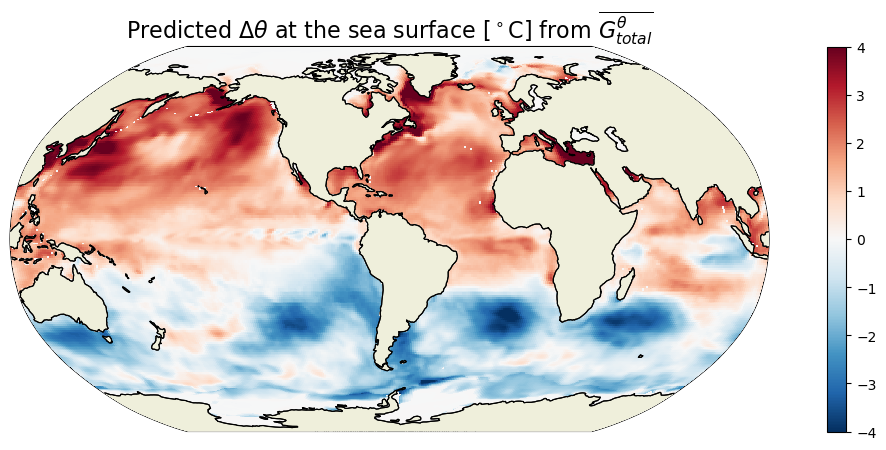

In [38]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              THETA_delta.isel(k=0),show_colorbar=True,\
                              cmin=-4, cmax=4, \
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);
plt.title(r'Predicted $\Delta \theta$ at the sea surface [$^\circ$C] from $\overline{G^\theta_{total}}$',fontsize=16);

We can sanity check the total ``THETA`` change that we found by multipling the time-mean ``THETA`` tendency with the number of seconds in the simulation by comparing that with the difference in ``THETA`` between the end of the last month and start of the first month. 

In [39]:
THETA_delta_method_2 = ds.THETA_snp.isel(time_snp=-1) - ds.THETA_snp.isel(time_snp=0)

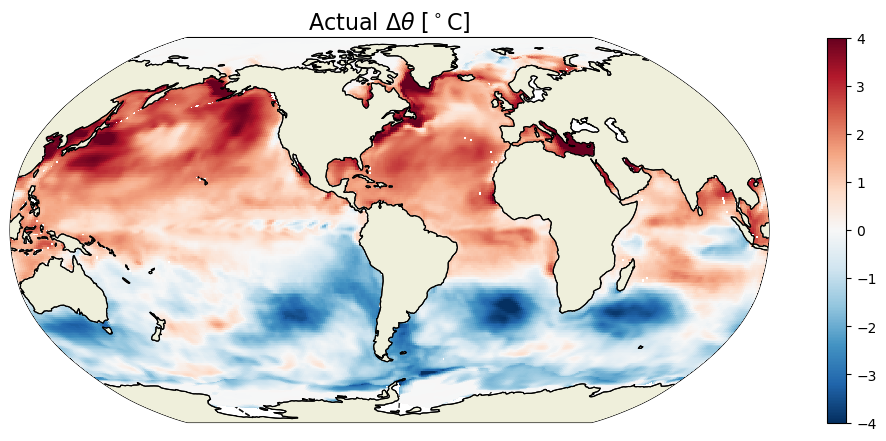

In [40]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              THETA_delta_method_2.isel(k=0),show_colorbar=True,\
                              cmin=-4, cmax=4, \
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);
plt.title(r'Actual $\Delta \theta$ [$^\circ$C]', fontsize=16);

#### Example $G^\theta_{total}$ field at a particular time

In [41]:
# get an array of YYYY, MM, DD, HH, MM, SS for 
#dETAN_dT_perSec at time index 100
curr_t_ind = 100
tmp = str(G_total.time.values[curr_t_ind])
print(tmp)

2001-05-16T12:00:00.000000000


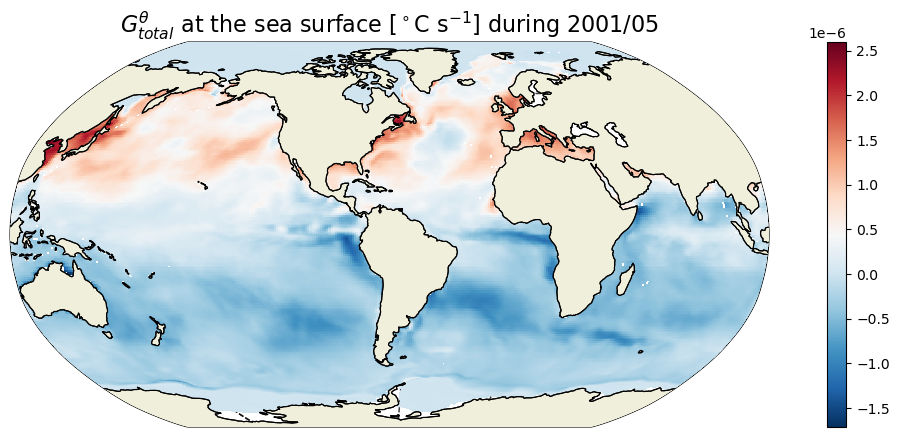

In [42]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_total.isel(time=curr_t_ind,k=0), show_colorbar=True,
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);

plt.title(r'$G^\theta_{total}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp)[0:4] +'/' + str(tmp)[5:7], fontsize=16);

For any given month the time rate of change of ``THETA`` is strongly dependent on the season. In the above we are looking at May 2001. We see positive ``THETA`` tendency in the northern hemisphere and cooling in the southern hemisphere.

## Calculate tendency due to advective convergence ($G^{\theta}_\textrm{advection}$)

The relevant fields from the diagnostic output here are
- `ADVx_TH`: U Component Advective Flux of Potential Temperature (degC m^3/s)
- `ADVy_TH`: V Component Advective Flux of Potential Temperature (degC m^3/s)
- `ADVr_TH`: Vertical Advective Flux of Potential Temperature (degC m^3/s)

The xgcm `grid` object is then used to take the convergence of the horizontal heat advection.

> **Note**: when using at least one recent version of `xgcm` (v0.8.1), errors were triggered when calling `diff_2d_vector`.
> As an alternative, the `diff_2d_flux_llc90` function is included below.

> **Note**: For the vertical fluxes `ADVr_TH`, `DFrE_TH`, and `DFrI_TH`, we need to make sure that sequence of dimensions are consistent.
> When loading the fields use `.transpose('time','tile','k_l','j','i')`. Otherwise, the divergences will be not correct (at least for `tile = 12`).

In [43]:
def da_replace_at_indices(da,indexing_dict,replace_values):
    # replace values in xarray DataArray using locations specified by indexing_dict
    array_data = da.data
    indexing_dict_bynum = {}
    for axis,dim in enumerate(da.dims):
        if dim in indexing_dict.keys():
            indexing_dict_bynum = {**indexing_dict_bynum,**{axis:indexing_dict[dim]}}
    ndims = len(array_data.shape)
    indexing_list = [':']*ndims
    for axis in indexing_dict_bynum.keys():
        indexing_list[axis] = indexing_dict_bynum[axis]
    indexing_str = ",".join(indexing_list)

    # using exec isn't ideal, but this works for both NumPy and Dask arrays
    exec('array_data['+indexing_str+'] = replace_values')        
    
    return da


def diff_2d_flux_llc90(flux_vector_dict):
    """
    A function that differences flux variables on the llc90 grid.
    Can be used in place of xgcm's diff_2d_vector.
    """

    u_flux = flux_vector_dict['X']
    v_flux = flux_vector_dict['Y']
    
    u_flux_padded = u_flux.pad(pad_width={'i_g':(0,1)},mode='constant',constant_values=np.nan)\
                            .chunk({'i_g':u_flux.sizes['i_g']+1})
    v_flux_padded = v_flux.pad(pad_width={'j_g':(0,1)},mode='constant',constant_values=np.nan)\
                            .chunk({'j_g':v_flux.sizes['j_g']+1})
    
    
    # u flux padding
    for tile in range(0,3):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+3,i_g=0).data)
    for tile in range(3,6):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              v_flux.isel(tile=12-tile,j_g=0,i=slice(None,None,-1)).data)
    u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':'6','i_g':'-1'},\
                                          u_flux.isel(tile=7,i_g=0).data)
    for tile in range(7,9):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+1,i_g=0).data)
    for tile in range(10,12):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+1,i_g=0).data)
        
    # v flux padding
    for tile in range(0,2):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+1,j_g=0).data)
    v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':'2','j_g':'-1'},\
                                          u_flux.isel(tile=6,j=slice(None,None,-1),i_g=0).data)
    for tile in range(3,6):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+1,j_g=0).data)
    v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':'6','j_g':'-1'},\
                                          u_flux.isel(tile=10,j=slice(None,None,-1),i_g=0).data)
    for tile in range(7,10):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+3,j_g=0).data)
    for tile in range(10,13):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              u_flux.isel(tile=12-tile,j=slice(None,None,-1),i_g=0).data)
    
    # take differences
    diff_u_flux = u_flux_padded.diff('i_g')
    diff_v_flux = v_flux_padded.diff('j_g')
    
    # include coordinates of input DataArrays and correct dimension/coordinate names
    diff_u_flux = diff_u_flux.assign_coords(u_flux.coords).rename({'i_g':'i'})
    diff_v_flux = diff_v_flux.assign_coords(v_flux.coords).rename({'j_g':'j'})

    diff_flux_vector_dict = {'X':diff_u_flux,'Y':diff_v_flux}
    
    return diff_flux_vector_dict

> **A note about memory usage**: Since the advection and diffusion calculations involve the full-depth ocean and are therefore memory intensive, we are going to be careful about limiting our memory usage at any given time: chunking our data in blocks that are sized based on our available memory, and clearing those blocks of data from our working memory space when we have finished computations with them. This is a little more complicated when using `Python` and `xarray` vs. some other computing languages, but here is the procedure we use:
> - Close the *first* dataset where the data are loaded from source files
> - Re-open the dataset so we clear any previously cached data (both the close and re-open seem to be necessary to clear the cache)
> - Carry out computations
> - Use `del` to delete any data variables where data was previously loaded using `compute`
> - Close the first dataset and repeat the cycle on the next loop iteration

> To make re-opening the dataset quicker, we will use a `pickle` object which saves the pointers created when calling `open_mfdataset` into memory. This is an important time-saver since we will be closing and re-opening this dataset a lot. For more background on why this procedure is being used, see the [Memory management in Python](https://ecco-v4-python-tutorial.readthedocs.io/Memory_management.html) tutorial.

In [44]:
# Set fluxes on land to zero (instead of NaN)
ds['ADVx_TH'] = ds.ADVx_TH.where(ecco_grid.hFacW.values > 0,0)
ds['ADVy_TH'] = ds.ADVy_TH.where(ecco_grid.hFacS.values > 0,0)
ds['ADVr_TH'] = ds.ADVr_TH.where(ecco_grid.hFacC.values > 0,0)

# transpose dimensions for xgcm (see note below)
ds['ADVr_TH'] = ds.ADVr_TH.transpose('time','tile','k_l','j','i')

# re-chunk arrays for better performance
ds['ADVx_TH'] = ds['ADVx_TH'].chunk({'time':1,'k':-1,'tile':-1,'j':-1,'i_g':-1})
ds['ADVy_TH'] = ds['ADVy_TH'].chunk({'time':1,'k':-1,'tile':-1,'j_g':-1,'i':-1})
ds['ADVr_TH'] = ds['ADVr_TH'].chunk({'time':1,'tile':-1,'k_l':-1,'j':-1,'i':-1})


# create pickled object with pointers to original flux files
import pickle
ecco_vars_int_pickled = pickle.dumps(ecco_vars_int)

# close ecco_vars_int dataset
ecco_vars_int.close()

> **Note**: In case of the volume budget (and salinity conservation), the surface forcing (`oceFWflx`) is already included at the top level (`k_l = 0`) in ``WVELMASS``.  Thus, to keep the surface forcing term explicitly represented, one needs to zero out the values of ``WVELMASS`` at the surface so as to avoid double counting (see the [Volume budget closure](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Volume_budget_closure.html) tutorial). This is not the case for the heat budget. `ADVr_TH` does not include the sea surface forcing. Thus, the vertical advective flux (at the air-sea interface) should not be zeroed out.

In [45]:
### Original code to compute G_advection is commented below
### (can use this if xgcm.diff_2d_vector is working properly
### and memory constraints allow)


# # compute horizontal components of flux divergence
# ADVxy_diff = grid.diff_2d_vector({'X' : ds.ADVx_TH, 'Y' : ds.ADVy_TH}, boundary = 'fill')

# # Convergence of horizontal advection (degC m^3/s)
# adv_hConvH = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))

# # Convergence of vertical advection (degC m^3/s)
# adv_vConvH = grid.diff(ds.ADVr_TH, 'Z', boundary='fill')

# # Sum horizontal and vertical convergences and divide by volume (degC/s)
# G_advection = (adv_hConvH + adv_vConvH)/vol


### End of original code block


def G_advection_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None):
    """Computes advection tendency for given time and k indices (k indices must be continuous, without gaps)"""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    if isinstance(k_isel,type(None)):
        k_isel = np.arange(0,ds.sizes['k'])

    if len(k_isel) > 1:
        if (np.nanmin(np.diff(np.asarray(k_isel))) < 1) or (np.nanmax(np.diff(np.asarray(k_isel))) > 1):
            raise ValueError('k_isel is not monotonically increasing or not continuous')        

    
    # re-open source dataset
    ecco_vars_int = pickle.loads(ecco_vars_int_pickled)
        
    ## compute horizontal convergence

    ADVx_TH = ds.ADVx_TH.isel(time=time_isel,k=k_isel)#.compute()
    ADVy_TH = ds.ADVy_TH.isel(time=time_isel,k=k_isel)#.compute()
    ADVxy_diff = diff_2d_flux_llc90({'X': ADVx_TH,\
                                     'Y': ADVy_TH})
    
    
    # Convergence of horizontal advection (degC m^3/s)
    adv_hConvH = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))
    
    # transpose dimensions
    adv_hConvH = adv_hConvH.transpose('time','tile','k','j','i')
    
    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    adv_hConvH = adv_hConvH.assign_coords({'time':ds.time[time_isel].data})#.compute()
        
    ## compute vertical convergence

    if k_isel[-1] == ds.sizes['k']-1:
        ADVr_TH = ds.ADVr_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0)#.compute()        
    else:
        ADVr_TH = ds.ADVr_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1))#.compute()
    adv_vConvH = ADVr_TH.diff('k_l').rename({'k_l':'k'})
    adv_vConvH = adv_vConvH.assign_coords({'k':ds.k[k_isel].data})
        
    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    adv_vConvH = adv_vConvH.assign_coords({'time':ds.time[time_isel].data})#.compute()
         

    ## Sum horizontal and vertical convergences and divide by volume (degC/s)
    G_advection = ((adv_hConvH + adv_vConvH)/vol)#.compute()
    
    # delete the variables where data was actually loaded into memory
    del ADVx_TH
    del ADVy_TH
    del adv_hConvH
    del ADVr_TH
    del adv_vConvH

    # close the original dataset where the fluxes were loaded from the source files (needed to clear the data from cache)
    ecco_vars_int.close()
    
    return G_advection



def monthly_tmean_aggregate(function,ds,ecco_vars_int_pickled,vol,month_length_weights,time_chunksize=1,time_isel=None,k_isel=None):
    """Compute time mean by cumulatively summing array over time_isel indices, weighted by month length.
       Includes variable time_chunksize to help us manage different memory environments;
       larger chunks run faster but require more system memory."""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    
    for time_chunk in range(int(np.ceil(len(time_isel)/time_chunksize))):
        curr_time_isel = time_isel[(time_chunksize*time_chunk):np.fmin(time_chunksize*(time_chunk+1),len(time_isel))]
        curr_array_computed = function(ds,ecco_vars_int_pickled,vol,time_isel=curr_time_isel,k_isel=k_isel)
        if time_chunk == 0:
            array_tmean = (month_length_weights.isel(time=curr_time_isel)*curr_array_computed).sum('time').compute()            
        else:
            array_tmean += (month_length_weights.isel(time=curr_time_isel)*curr_array_computed).sum('time').compute()            

        del curr_array_computed        
    
    return array_tmean

In [46]:
G_advection = G_advection_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None)

### Plot the time-mean $G^{\theta}_\textrm{advection}$

In [47]:
import psutil 

mem_avail = psutil.virtual_memory().available
print('Available memory:',mem_avail/(10**9),'GB')

# chunk size to use when computing time mean with monthly_tmean_aggregate (not the same as dask chunksize)
time_chunksize = int(np.round(mem_avail/(2**28)))
time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
print('Using time_chunksize =',time_chunksize)

Available memory: 22.715191296 GB
Using time_chunksize = 85


In [48]:
# %%time
# plt.figure(figsize=(15,15))

# for idx, k in enumerate([0,1,25]):
#     p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
#                                       monthly_tmean_aggregate(G_advection_compute,\
#                                                               ds,ecco_vars_int_pickled,vol,month_length_weights,\
#                                                               time_chunksize=time_chunksize,k_isel=[k]),\
#                                       show_colorbar=True,
#                                       cmin=-1e-6, cmax=1e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
#                                       subplot_grid=[3,1,idx+1]);
#     p[1].set_title(r'$\overline{G^\theta_{advection}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
#                    %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

### Example $G^{\theta}_\textrm{advection}$ field at a particular time

In [49]:
curr_t_ind = 100
tmp = str(ds.time.values[curr_t_ind])
print(tmp)

2001-05-16T12:00:00.000000000


/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 15.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 15.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


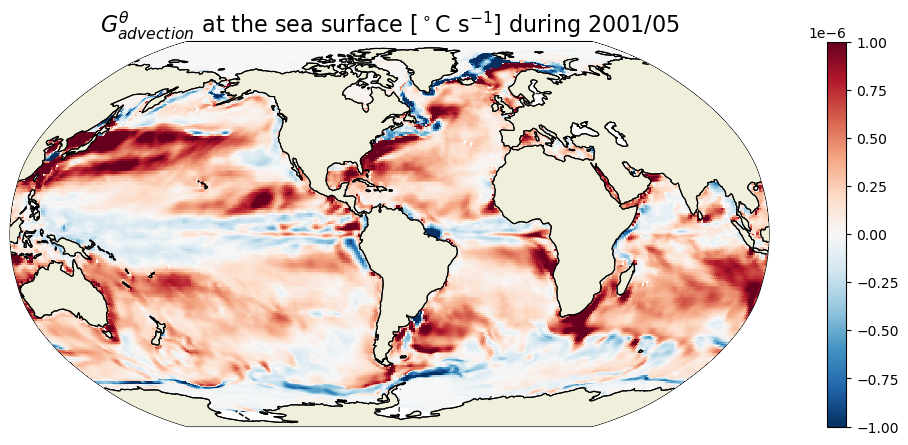

In [50]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                              G_advection_compute(ds,ecco_vars_int_pickled,vol,time_isel=[curr_t_ind],k_isel=[0]),\
                              show_colorbar=True,
                              cmin=-1e-6, cmax=1e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{advection}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp)[0:4] +'/' + str(tmp)[5:7], fontsize=16)
plt.show()

## Calculate tendency due to diffusive convergence ($G^{\theta}_\textrm{diffusion}$)

The relevant fields from the diagnostic output here are
- `DFxE_TH`: U Component Diffusive Flux of Potential Temperature (degC m^3/s)
- `DFyE_TH`: V Component Diffusive Flux of Potential Temperature (degC m^3/s)
- `DFrE_TH`: Vertical Diffusive Flux of Potential Temperature (Explicit part) (degC m^3/s)
- `DFrI_TH`: Vertical Diffusive Flux of Potential Temperature (Implicit part) (degC m^3/s)
> **Note**: Vertical diffusion has both an explicit (`DFrE_TH`) and an implicit (`DFrI_TH`) part.

As with advective fluxes, we use the xgcm `grid` object to calculate the convergence of horizontal heat diffusion.

In [51]:
# Set fluxes on land to zero (instead of NaN)
ds['DFxE_TH'] = ds.DFxE_TH.where(ecco_grid.hFacW.values > 0,0)
ds['DFyE_TH'] = ds.DFyE_TH.where(ecco_grid.hFacS.values > 0,0)
ds['DFrE_TH'] = ds.DFrE_TH.where(ecco_grid.hFacC.values > 0,0)
ds['DFrI_TH'] = ds.DFrI_TH.where(ecco_grid.hFacC.values > 0,0)

# tranpose dimensions
ds['DFrE_TH'] = ds.DFrE_TH.transpose('time','tile','k_l','j','i')
ds['DFrI_TH'] = ds.DFrI_TH.transpose('time','tile','k_l','j','i')

# re-chunk arrays for better performance
ds['DFxE_TH'] = ds['DFxE_TH'].chunk({'time':12,'k':-1,'tile':-1,'j':-1,'i_g':-1})
ds['DFyE_TH'] = ds['DFyE_TH'].chunk({'time':12,'k':-1,'tile':-1,'j_g':-1,'i':-1})
ds['DFrE_TH'] = ds['DFrE_TH'].chunk({'time':12,'k_l':-1,'tile':-1,'j':-1,'i':-1})
ds['DFrI_TH'] = ds['DFrI_TH'].chunk({'time':12,'k_l':-1,'tile':-1,'j':-1,'i':-1})

In [52]:
### Original code to compute G_diffusion is commented below
### (can use this if xgcm.diff_2d_vector is working properly
### and memory constraints allow)


# # compute horizontal components of flux divergence
# DFxyE_diff = grid.diff_2d_vector({'X' : ds.DFxE_TH, 'Y' : ds.DFyE_TH}, boundary = 'fill')

# # Convergence of horizontal diffusion (degC m^3/s)
# dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

# # Convergence of vertical diffusion (degC m^3/s)
# dif_vConvH = grid.diff(DFrE_TH + DFrI_TH, 'Z', boundary='fill')

# # Sum horizontal and vertical convergences and divide by volume (degC/s)
# G_diffusion = (dif_hConvH + dif_vConvH)/vol


### End of original code block


# complete horizontal divergence calculation, 12 time indices (1 year) at a time

def G_diffusion_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None):
    """Computes diffusion tendency for given time and k indices (k indices must be continuous, without gaps)"""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    if isinstance(k_isel,type(None)):
        k_isel = np.arange(0,ds.sizes['k'])

    if len(k_isel) > 1:
        if (np.nanmin(np.diff(np.asarray(k_isel))) < 1) or (np.nanmax(np.diff(np.asarray(k_isel))) > 1):
            raise ValueError('k_isel is not monotonically increasing or not continuous')        

    
    # re-open source dataset
    ecco_vars_int = pickle.loads(ecco_vars_int_pickled)
    
    ## compute horizontal convergence

    DFxE_TH = ds.DFxE_TH.isel(time=time_isel,k=k_isel)#.compute()
    DFyE_TH = ds.DFyE_TH.isel(time=time_isel,k=k_isel)#.compute()
    DFxyE_diff = diff_2d_flux_llc90({'X': DFxE_TH,\
                                     'Y': DFyE_TH})
    
    # Convergence of horizontal advection (degC m^3/s)
    dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

    # transpose dimensions
    dif_hConvH = dif_hConvH.transpose('time','tile','k','j','i')
    
    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    dif_hConvH = dif_hConvH.assign_coords({'time':ds.time[time_isel].data})#.compute()
    
    ## compute vertical convergence
    
    if k_isel[-1] == ds.sizes['k']-1:
        DFrE_TH = ds.DFrE_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0)#.compute()
        DFrI_TH = ds.DFrI_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0)#.compute()        
    else:
        DFrE_TH = ds.DFrE_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1))#.compute()
        DFrI_TH = ds.DFrI_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1))#.compute()        
    dif_vConvH = (DFrE_TH + DFrI_TH).diff('k_l').rename({'k_l':'k'})
    dif_vConvH = dif_vConvH.assign_coords({'k':ds.k[k_isel].data})
    
    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    dif_vConvH = dif_vConvH.assign_coords({'time':ds.time[time_isel].data})#.compute()
        
    ## Sum horizontal and vertical convergences and divide by volume (degC/s)
    G_diffusion = ((dif_hConvH + dif_vConvH)/vol)#.compute()
    
    # delete the variables where data was actually loaded into memory
    del DFxE_TH
    del DFyE_TH
    del dif_hConvH
    del DFrE_TH
    del DFrI_TH
    del dif_vConvH

    # close the original dataset where the fluxes were loaded from the source files (needed to clear the data from cache)
    ecco_vars_int.close()
    
    return G_diffusion

### Plot the time-mean $G^{\theta}_\textrm{diffusion}$

In [53]:
mem_avail = psutil.virtual_memory().available
print('Available memory:',mem_avail/(10**9),'GB')

# chunk size to use when computing time mean with monthly_tmean_aggregate (not the same as dask chunksize)
time_chunksize = int(np.round(mem_avail/(2**28)))
time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
print('Using time_chunksize =',time_chunksize)

Available memory: 22.583668736 GB
Using time_chunksize = 84


In [54]:
# %%time 
# plt.figure(figsize=(15,15))

# for idx, k in enumerate([0,1,25]):
#     p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
#                                       monthly_tmean_aggregate(G_diffusion_compute,\
#                                                               ds,ecco_vars_int_pickled,vol,month_length_weights,\
#                                                               time_chunksize=time_chunksize,k_isel=[k]),\
#                                       show_colorbar=True,
#                                       cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
#                                       subplot_grid=[3,1,idx+1]);
#     p[1].set_title(r'$\overline{G^\theta_{diffusion}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
#                    %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

### Example $G^{\theta}_\textrm{diffusion}$ field at a particular time

In [55]:
curr_t_ind = 100
tmp = str(ds.time.values[curr_t_ind])
print(tmp)

2001-05-16T12:00:00.000000000


/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 15.69 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 15.69 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


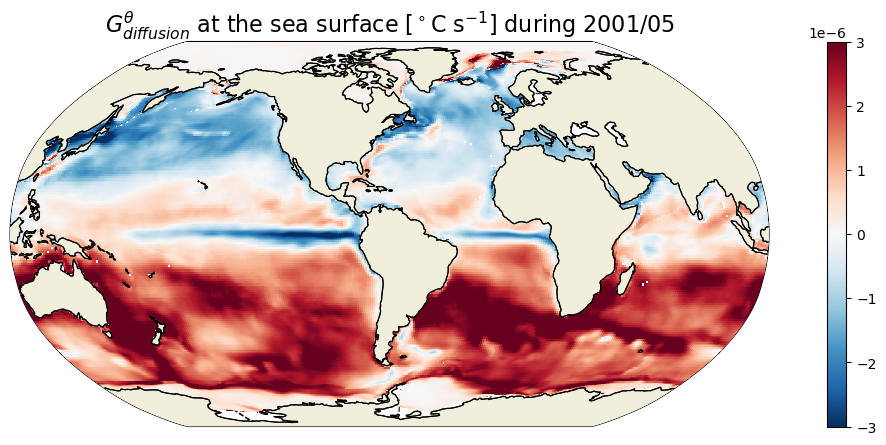

In [56]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                              G_diffusion_compute(ds,ecco_vars_int_pickled,vol,time_isel=[curr_t_ind],k_isel=[0]),\
                              show_colorbar=True,
                              cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{diffusion}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp)[0:4] +'/' + str(tmp)[5:7], fontsize=16)
plt.show()

In [57]:
G_diffusion=G_diffusion_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None)


## Calculate tendency due to forcing ($G^{\theta}_\textrm{forcing}$)
Finally, we evaluate the local forcing term due to surface heat and geothermal fluxes.

### Surface heat flux
For the surface contribution, there are two relevant model diagnostics:
- `TFLUX`: total heat flux (match heat-content variations) (W/m^2)
- `oceQsw`: net Short-Wave radiation (+=down) (W/m^2)

#### Defining terms needed for evaluating surface heat forcing

In [58]:
Z = ecco_grid.Z.compute()
RF = np.concatenate([ecco_grid.Zp1.values[:-1],[np.nan]])

>**Note**: `Z` and `Zp1` are used in deriving surface heat penetration. MATLAB code uses `RF` from `mygrid` structure.

In [59]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [60]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [61]:
# Create xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

#### Compute vertically penetrating flux
Given the penetrating nature of the shortwave term, to properly evaluate the local forcing term, `oceQsw` must be removed from `TFLUX` (which contains the net latent, sensible, longwave, and shortwave contributions) and redistributed vertically.

In [62]:
## Land masks
# Make copy of hFacC
mskC = ecco_grid.hFacC.copy(deep=True).compute()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [63]:
# Shortwave flux below the surface (W/m^2)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*ds.oceQsw).transpose('time','tile','k','j','i')

In [64]:
# Surface heat flux (W/m^2)
forcH_surf = ((ds.TFLUX - (1-(q1[0]-q2[0]))*ds.oceQsw)\
              *mskC[0]).transpose('time','tile','j','i').assign_coords(k=0).expand_dims('k')

In [65]:
# Full-depth sea surface forcing (W/m^2)
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time','tile','k','j','i')

In [66]:
forcH

<xarray.DataArray (time: 323, tile: 13, k: 50, j: 90, i: 90)> Size: 14GB
dask.array<transpose, shape=(323, 13, 50, 90, 90), dtype=float64, chunksize=(1, 13, 49, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * k        (k) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03

### Geothermal flux

The geothermal flux contribution is not accounted for in any of the standard model diagnostics provided as output. Rather, this term, which is time invariant, is provided in the input file `geothermalFlux.bin` contained in the ancillary data archive. This archive can be downloaded from [PO.DAAC](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_ANCILLARY_DATA_V4R4/ancillary_data_input_forcing_ECCO_V4r4.tar.gz), though accessing it there requires downloading a much larger tarball of files (~192 GB). So, for the time being, the `geothermalFlux.bin` file is also stored on the tutorial Github and can be downloaded [here](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/raw/master/misc/geothermalFlux.bin).

> **Note**: The code cell below assumes `geothermalFlux.bin` has been placed in `~/Downloads`, or is in the cloned GitHub repository under `~/ECCO-v4-Python-Tutorial/misc` or `~/git_repos/ECCO-v4-Python-Tutorial/misc`. Change the directory `geoflx_dir` as needed.

In [67]:
# Load the geothermal heat flux using the routine 'read_llc_to_tiles'.
geoflx_filename = 'geothermalFlux.bin'
# if exists(join(user_home_dir,'Downloads',geoflx_filename)):
#     geoflx_dir = join(user_home_dir,'Downloads')
# elif exists(join(user_home_dir,'ECCO-v4-Python-Tutorial','misc',geoflx_filename)):
#     geoflx_dir = join(user_home_dir,'ECCO-v4-Python-Tutorial','misc')
# elif exists(join(user_home_dir,'git_repos','ECCO-v4-Python-Tutorial','misc',geoflx_filename)):
#     geoflx_dir = join(user_home_dir,'git_repos','ECCO-v4-Python-Tutorial','misc')
# elif exists(join(user_home_dir,'/efs/efs_ecco/ECCO/','V4/r5/input/input_forcing/other/',geoflx_filename)):
geoflx_dir = join(user_home_dir,'efs_ecco/ECCO/','V4/r5/input/input_forcing/other/')
# else:
#     raise FilePathError('Can not locate '+geoflx_filename+' in default directories.\n'\
#                         +'Please specify geoflx_dir.')
# # geoflx_dir = join(user_home_dir,'Downloads')
geoflx = ecco.read_llc_to_tiles(geoflx_dir, 'geothermalFlux.bin')

load_binary_array: loading file /home/jovyan/efs_ecco/ECCO/V4/r5/input/input_forcing/other/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


The geothermal flux dataset needs to be saved as an xarray data array with the same format as the model output.

In [68]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
geoflx_llc = xr.DataArray(geoflx,coords={'tile': ecco_monthly_mean.tile.values,
                                         'j': ecco_monthly_mean.j.values,
                                         'i': ecco_monthly_mean.i.values},dims=['tile','j','i'])

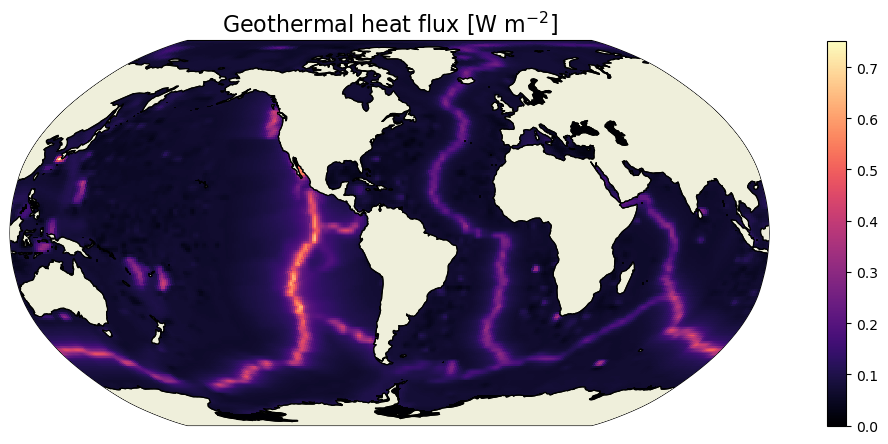

In [69]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, geoflx_llc,show_colorbar=True,cmap='magma', 
                              user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'Geothermal heat flux [W m$^{-2}$]', fontsize=16)
plt.show()

Geothermal flux needs to be a three dimensional field since the sources are distributed along the ocean floor at various depths. This requires a three dimensional mask.

In [70]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)

mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

# Create 3d field of geothermal heat flux
geoflx3d = geoflx_llc * mskb.transpose('k','tile','j','i')
GEOFLX = geoflx3d.transpose('k','tile','j','i')
GEOFLX.attrs = {'standard_name': 'GEOFLX','long_name': 'Geothermal heat flux','units': 'W/m^2'}

### Total forcing ($G^{\theta}_\textrm{forcing}$)

In [71]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
G_forcing = ((forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)

### Plot the time-mean $G^{\theta}_\textrm{forcing}$

In [72]:
G_forcing_mean = (G_forcing*month_length_weights).sum('time')

In [73]:
# %%time

# plt.figure(figsize=(15,15))

# for idx, k in enumerate([0,1,25]):
#     p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_forcing_mean.isel(k=k),show_colorbar=True,
#                                       cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
#                                       subplot_grid=[3,1,idx+1]);
#     p[1].set_title(r'$\overline{G^\theta_{forcing}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
#                    %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

$\overline{G^\theta_{forcing}}$ is focused at the sea surface and much smaller (essentially zero) at depth. $\overline{G^\theta_{forcing}}$ is negative for most of the ocean (away from the equator). The spatial pattern in the surface forcing is the same as for diffusion but with opposite sign (see maps for $\overline{G^\theta_{diffusion}}$ above). This makes sense as forcing is to a large extent balanced by diffusion within the mixed layer.

### Example $G^{\theta}_\textrm{forcing}$ field at a particular time

In [74]:
curr_t_ind = 100
tmp = str(G_forcing.time.values[curr_t_ind])
print(tmp)

2001-05-16T12:00:00.000000000


/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 40.58 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 40.58 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


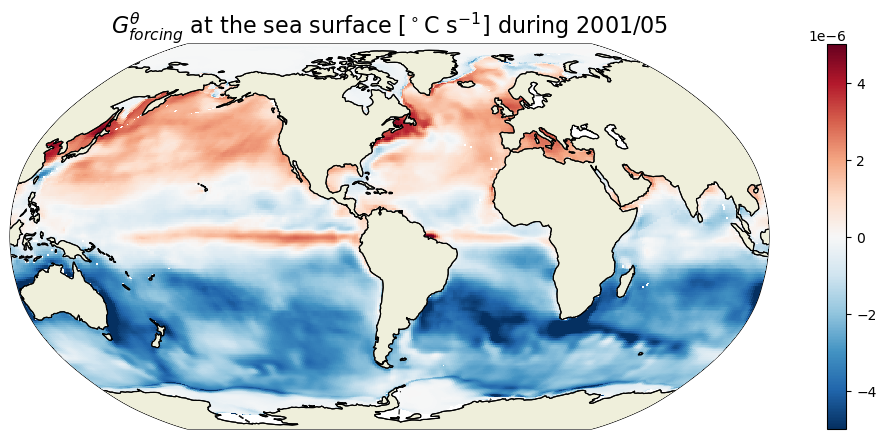

In [75]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_forcing.isel(time=curr_t_ind,k=0),show_colorbar=True,
                              cmin=-5e-6, cmax=5e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{forcing}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp)[0:4] +'/' + str(tmp)[5:7], fontsize=16)
plt.show()

## Save to dataset
Now that we have all the terms evaluated, let's save them to a dataset. Here are two examples:
- Zarr is a new format that is used for cloud storage.
- Netcdf is the more traditional format that most people are familiar with.

When saving this heat budget dataset, the zarr file is ~15 GB, while the NetCDF file is ~53 GB. So zarr can be more efficient for storage.

### Add all variables to a new dataset

In [76]:
G_forcing

<xarray.DataArray (time: 323, tile: 13, k: 50, j: 90, i: 90)> Size: 14GB
dask.array<truediv, shape=(323, 13, 50, 90, 90), dtype=float64, chunksize=(1, 13, 49, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * k        (k) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03

In [114]:
##This code did not write the advection and diffusion term!!!!! I had to modify it to save them
### OKay, I'm gonna have to save the terms in separate files
varnames = ['G_forcing']

G_total = G_total.transpose('time','tile','k','j','i')

# adv_diff_written = True

ds_budg = xr.Dataset(data_vars={})
for varname in varnames:
    # if varname not in globals():
        # create empty dask arrays for G_advection and G_diffusion (to be written later)
        # import dask.array as da
        # ds_budg[varname] = (['time','tile','k','j','i'],\
        #                     da.empty((ds.sizes['time'],13,50,90,90),dtype='float32',\
        #                             chunks=(1,13,50,90,90)))
        # # adv_diff_written = False
    # else:
    ds_budg[varname] = globals()[varname].chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})        

In [115]:
# # Add surface forcing (degC/s)
# ds_budg['Qnet'] = ((forcH /(rhoconst*c_p))\
#                   /(ecco_grid.hFacC*ecco_grid.drF)).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [116]:
# # Add shortwave penetrative flux (degC/s)
# #Since we only are interested in the subsurface heat flux we need to zero out the top cell
# SWpen = ((forcH_subsurf /(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)).where(forcH_subsurf.k>0).fillna(0.)
# ds_budg['SWpen'] = SWpen.where(ecco_grid.hFacC>0).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

> **Note**: `Qnet` and `SWpen` are included in `G_forcing` and are not necessary to close the heat budget. 

In [117]:
ds_budg.time.encoding = {}
ds_budg = ds_budg.reset_coords(drop=True)

In [118]:
ds_budg

<xarray.Dataset> Size: 14GB
Dimensions:    (i: 90, j: 90, tile: 13, time: 323, k: 50)
Coordinates:
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
  * k          (k) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Data variables:
    G_forcing  (time, tile, k, j, i) float64 14GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 80.75 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


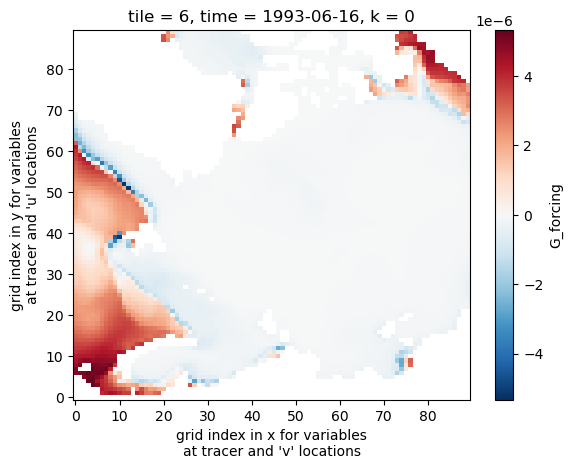

In [119]:
ds_budg.G_forcing.isel(time=5, k=0, tile=6).plot()

### Save to zarr

In [120]:
import zarr

In [121]:
# save_dir is set to ~/Downloads below;
# change if you want to save somewhere else
save_dir = join(user_home_dir,'efs_ecco/asiddiqu/eccov4r5_heat_budget_terms/')

# first query how much storage is free
# the zarr file will occupy ~15 GB, so require 20 GB free storage as a buffer

import shutil
free_storage = shutil.disk_usage(save_dir).free
print(f'Free storage: {free_storage/(10**9)} GB')

# query how much memory is available
# (influences how this large archive will be computed and stored)
mem_avail = psutil.virtual_memory().available
print('Available memory:',mem_avail/(10**9),'GB')

Free storage: 9223360658.41791 GB
Available memory: 20.4961792 GB


In [122]:
from dask.diagnostics import ProgressBar

In [123]:
for var in ds_budg.data_vars:
    if ds_budg[var].dtype == 'float64':
        ds_budg[var] = ds_budg[var].astype('float32')

ds_budg

<xarray.Dataset> Size: 7GB
Dimensions:    (i: 90, j: 90, tile: 13, time: 323, k: 50)
Coordinates:
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
  * k          (k) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Data variables:
    G_forcing  (time, tile, k, j, i) float32 7GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>

In [127]:
# to save budget as netcdf, set save_netcdf = True
save_netcdf = True

# encoding = {var: {"dtype": "float32", "zlib": True, "complevel": 1} for var in ds_budg.data_vars}

# the netcdf file will occupy ~53 GB, so require 60 GB free storage as a buffer
if save_netcdf:
    if free_storage >= 60*(10**9):
        with ProgressBar():
            ds_budg.to_netcdf(join(save_dir,'eccov4r5_budg_heat_frc.nc'), compute=True)
    else:
        print('Insufficient storage to save global budget terms to disk as netcdf')

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 83.17 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
# %pdb on

# ### Original code to save dataset to zarr archive

# # zarr_save_location = join(save_dir,'eccov4r4_budg_heat')
# # ds.to_zarr(zarr_save_location)

# ### End of original code block


# def zarr_archive_tloop(function,save_location,varname,\
#                        ds,ecco_vars_int_pickled,vol,time_chunksize=1,time_isel=None,k_isel=None):
#     """
#     Compute array using function and save to zarr archive, 
#     by looping through time chunks of size time_chunksize.
#     This has cleaner memory usage than just relying on dask chunking.
#     """

#     if isinstance(time_isel,type(None)):
#         time_isel = np.arange(0,ds.sizes['time'])
    
#     for time_chunk in range(int(np.ceil(len(time_isel)/time_chunksize))):
#         if exists(save_location):
#             ds_to_write = xr.open_zarr(save_location)
#         curr_time_isel = time_isel[(time_chunksize*time_chunk):np.fmin(time_chunksize*(time_chunk+1),len(time_isel))]
#         ds_to_write[varname] = da_replace_at_indices(ds_to_write[varname],\
#                                                     {'time':str(curr_time_isel[0])+':'+str(curr_time_isel[-1]+1)},\
#                                                     function(ds,ecco_vars_int_pickled,vol,time_isel=curr_time_isel,k_isel=k_isel))
#         ds_to_write[varname].to_dataset().to_zarr(save_location,mode="a")
#         ds_to_write.close()


# # the zarr archive will occupy ~15 GB, so require 20 GB free storage as a buffer
# zarr_save_location = join(save_dir,'eccov4r4_budg_heat')
# if free_storage >= 20*(10**9):
#     # chunk size to use when computing G_advection and G_diffusion (not the same as dask chunksize)
#     time_chunksize = int(np.round(mem_avail/(10**9)))
#     # time_chunksize = ds.sizes['time']
#     time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
#     print('Using time_chunksize =',time_chunksize)
#     if mem_avail >= 20*(10**9):
#         if not adv_diff_written:
#             ds_budg['G_advection'] = G_advection_compute(ds,ecco_vars_int_pickled,vol)
#             ds_budg['G_diffusion'] = G_diffusion_compute(ds,ecco_vars_int_pickled,vol)
#         with ProgressBar():
#             ds_budg.to_zarr(zarr_save_location)
#     else:
#         ecco_vars_int.close()
#         for varname in ds_budg.data_vars:
#             ds_budg[varname].to_dataset().to_zarr(zarr_save_location,mode="a")                
#             if varname in ['G_advection','G_diffusion']:                
#                 zarr_archive_tloop(eval(varname+'_compute'),zarr_save_location,varname,\
#                                    ds,ecco_vars_int_pickled,vol,time_chunksize=time_chunksize)
# else:
#     print('Insufficient storage to save global budget terms to disk as zarr')

## Load budget variables from file
After having saved the budget terms to file, we can load the dataset like this

In [82]:
import xarray as xr
# Load terms from netcdf file
save_dir = ('/home/jovyan/efs_ecco/asiddiqu/eccov4r5_heat_budget_terms/')
G_budget = xr.open_mfdataset(save_dir+'eccov4r4_budg_heat.nc')


In [83]:
G_budget

<xarray.Dataset> Size: 61GB
Dimensions:      (i: 90, j: 90, k: 50, tile: 13, time: 323)
Coordinates:
  * i            (i) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j            (j) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k            (k) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile         (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time         (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
Data variables:
    G_total      (time, tile, k, j, i) float32 7GB dask.array<chunksize=(323, 13, 50, 90, 90), meta=np.ndarray>
    G_advection  (time, tile, k, j, i) float32 7GB dask.array<chunksize=(323, 13, 50, 90, 90), meta=np.ndarray>
    G_diffusion  (time, tile, k, j, i) float32 7GB dask.array<chunksize=(323, 13, 50, 90, 90), meta=np.ndarray>
    G_forcing    (time, tile, k, j, i) float64 14GB dask.array<chunksize=(323, 13, 50, 90, 90), meta=np.ndarray>
    Qnet         (time, tile, k, j, i) float64 14GB dask.array<chunksize=(323, 13, 50, 90, 90), meta=np.ndarray>
    SWpen        (time, tile, k, j, i) float64 14GB dask.array<chunksize=(323, 13, 50, 90, 90), meta=np.ndarray>

In [84]:
G_budget = G_budget.drop('SWpen')

/tmp/ipykernel_179/2272466584.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  G_budget = G_budget.drop('SWpen')


In [85]:
G_budget.nbytes*1e-9

47.616663556000006

In [86]:
G_budget = G_budget.chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})  
G_budget

<xarray.Dataset> Size: 48GB
Dimensions:      (i: 90, j: 90, k: 50, tile: 13, time: 323)
Coordinates:
  * i            (i) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j            (j) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k            (k) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile         (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time         (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
Data variables:
    G_total      (time, tile, k, j, i) float32 7GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    G_advection  (time, tile, k, j, i) float32 7GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    G_diffusion  (time, tile, k, j, i) float32 7GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    G_forcing    (time, tile, k, j, i) float64 14GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    Qnet         (time, tile, k, j, i) float64 14GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>

In [87]:
G_total_tendency = G_budget.G_total
G_advection = G_budget.G_advection
G_diffusion = G_budget.G_diffusion
G_forcing = G_budget.G_forcing
Qnet = G_budget.Qnet

## Comparison between LHS and RHS of the budget equation

In [88]:
# Total convergence
ConvH = G_advection + G_diffusion

In [89]:
# Sum of terms in RHS of equation
rhs = ConvH + G_forcing

In [90]:
rhs

<xarray.DataArray (time: 323, tile: 13, k: 50, j: 90, i: 90)> Size: 14GB
dask.array<add, shape=(323, 13, 50, 90, 90), dtype=float64, chunksize=(1, 13, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16

### Map of residuals

In [94]:
res = ((rhs-G_total).sum(dim='k')*month_length_weights).sum(dim='time').compute()

KilledWorker: Attempted to run task ('open_dataset-G_forcing-80c7aadd776655132087c4e61f88e4e8', 0, 0, 0, 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:33859. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
plt.figure(figsize=(15,5))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, res,
                              cmin=-5e-12, cmax=5e-12, show_colorbar=True, cmap='RdBu_r',dx=0.2, dy=0.2)
plt.title(r'Residual $\partial \theta / \partial t$ [$^\circ$C s$^{-1}$]: RHS - LHS', fontsize=16)
plt.show()

The residual (summed over depth and time) is essentially zero everywhere. What if we omit the geothermal heat flux?